# The Hungarian Maximum Likelihood Trick

*by Louis Abraham*

You can download the notebook from https://louisabraham.github.io/notebooks/hungarian_trick.ipynb

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1 toc-item"><a href="#Data-generator" data-toc-modified-id="Data-generator-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data generator</a></div><div class="lev1 toc-item"><a href="#Simple-model:-SVM" data-toc-modified-id="Simple-model:-SVM-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Simple model: SVM</a></div><div class="lev1 toc-item"><a href="#Multiple-digits-classification" data-toc-modified-id="Multiple-digits-classification-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Multiple digits classification</a></div><div class="lev1 toc-item"><a href="#The-Hungarian-Trick" data-toc-modified-id="The-Hungarian-Trick-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>The Hungarian Trick</a></div><div class="lev1 toc-item"><a href="#Results" data-toc-modified-id="Results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Results</a></div><div class="lev1 toc-item"><a href="#Discussion" data-toc-modified-id="Discussion-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Discussion</a></div>

# Introduction

This notebook is about a cool (possibly novel) idea I had in a real world example.

I wanted to recognize the digits in images like this (because why not?):

<img src="../static/robot.jpg" width="400">

I knew all the digits would be different, and wanted to use this information to boost my predictions.

However, I will only present images from MNIST in this notebook, to avoid being distracted by image processing.

# Data generator

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
import skimage.transform

np.random.seed(1337)
np.set_printoptions(suppress=True)

mnist = fetch_mldata('MNIST original')

DIM = 16
X, y = mnist.data, mnist.target

def preprocess(x):
    im = x.reshape(28, 28)
    im = skimage.transform.resize(im, (DIM, DIM), anti_aliasing=True, mode='reflect')
    return im.flatten()

def sample():
    i = np.random.randint(len(X))
    return preprocess(X[i]), y[i]

TRAIN = 5000
TEST = 1000
X_train, y_train = map(np.array, zip(*(sample() for _ in range(TRAIN))))
X_test, y_test = map(np.array, zip(*(sample() for _ in range(TEST))))

print('Dataset shape:', X.shape)

Dataset shape: (70000, 784)


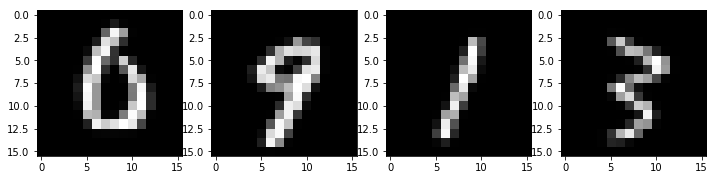

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 7)

for i in range(4):
    plt.subplot(141+i)
    plt.imshow(X_train[i].reshape(DIM, DIM), cmap='gray')
plt.show()

# Simple model: SVM

I don't really care about the final accuracy, but use SVMs for the sake of simplicity.

If you don't know about them, the [Wikipedia article](https://en.wikipedia.org/wiki/Support_vector_machine) is well written.

In [3]:
from time import time

from sklearn import svm, metrics

# Took the parameters from
# https://github.com/ksopyla/svm_mnist_digit_classification
classifier = svm.SVC(C=5, gamma=0.05, probability=True)

t = time()
classifier.fit(X_train, y_train)
print('Training time: %is' % (time() - t))

predicted = classifier.predict(X_test)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, predicted))

Training time: 16s
Classification report for classifier SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99        98
        1.0       0.98      0.96      0.97       126
        2.0       0.95      0.97      0.96       107
        3.0       0.95      0.94      0.95       123
        4.0       0.92      0.99      0.95        96
        5.0       0.95      0.95      0.95        80
        6.0       0.97      0.98      0.97        89
        7.0       0.96      0.96      0.96       100
        8.0       0.95      0.95      0.95        81
        9.0       0.98      0.91      0.94       100

avg / total       0.96      0.96      0.96      1000


Confusion matrix:
[[ 98   0   0   0   0   0   0   0   0   0]
 [  0 121   3   0   2 

# Multiple digits classification

As I explained above, I want to test on batches with different digits and exploit the information.

Here is what the labels look like:

In [4]:
import random

N_DIGITS = 7
TEST2 = 500

reverse_labels = {digit: np.flatnonzero(mnist.target==digit) for digit in range(10)}

testing_indexes = np.array([[random.choice(reverse_labels[i])
                            for i in random.sample(range(10), N_DIGITS)]
                           for _ in range(TEST2)])

y[testing_indexes[:10]].astype(int)

array([[5, 1, 6, 9, 2, 8, 7],
       [0, 3, 2, 5, 4, 8, 6],
       [5, 9, 2, 3, 4, 1, 7],
       [5, 8, 1, 6, 7, 3, 2],
       [5, 6, 2, 7, 8, 4, 3],
       [4, 8, 0, 6, 3, 9, 7],
       [3, 7, 4, 1, 8, 0, 6],
       [8, 6, 5, 2, 1, 4, 0],
       [6, 9, 0, 5, 2, 8, 1],
       [3, 8, 1, 0, 5, 2, 4]])

We say the model is correct on a batch if its predictions are correct for all `N_DIGITS` images of the batch.

In [5]:
testing_indexes_flat = testing_indexes.flatten()

X_test_2_flat = np.array(list(map(preprocess, X[testing_indexes_flat])))
X_test_2 = X_test_2_flat.reshape(TEST2, N_DIGITS, DIM * DIM)
y_test_2 = y[testing_indexes]

predicted = classifier.predict(X_test_2_flat).reshape(TEST2, N_DIGITS)
accuracy = (predicted == y_test_2).mean()
accuracy_multi = (predicted == y_test_2).all(axis=1).mean()

print('Accuracy for single digit prediction: %.01f%%' % (100 * accuracy))
print('Accuracy for single digit power N_DIGITS: %.01f%%' % (100 * accuracy ** N_DIGITS))
print('Accuracy for multiple digits prediction: %.01f%%' % (100 * accuracy_multi))

Accuracy for single digit prediction: 95.7%
Accuracy for single digit power N_DIGITS: 73.4%
Accuracy for multiple digits prediction: 73.6%


As expected, the accuracy on the new task is necessarily less.

But what if we could exploit the fact that the labels are different in a batch?

# The Hungarian Trick

Look at what we get for some predictions:

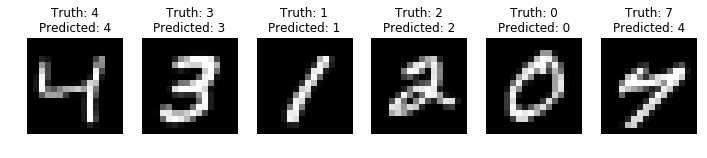

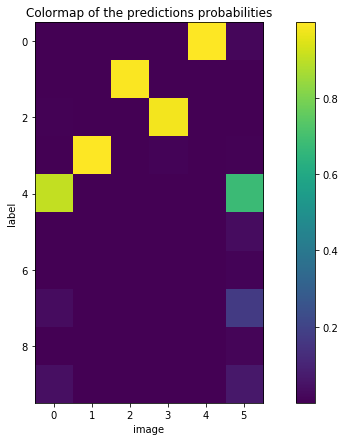

In [6]:
l = [24754, 18623, 5923, 12665, 0, 42051]
pred = classifier.predict(list(map(preprocess, X[l])))
prob = classifier.predict_proba(list(map(preprocess, X[l])))

plt.rcParams["figure.figsize"] = (12, 7)
for i, index in enumerate(l):
    plt.subplot(1, len(l), i+1)
    plt.title('Truth: %i\nPredicted: %i' % (y[index], pred[i]))
    plt.axis('off')
    plt.imshow(preprocess(X[index]).reshape(DIM, DIM), cmap='gray')
plt.show()

plt.title('Colormap of the predictions probabilities')
plt.imshow(prob.T)
plt.xlabel('image')
plt.ylabel('label')
plt.colorbar()
plt.show()

As you can see, although the overall result is good, in some cases it can make errors.

On the example above (how convenient!), the classifier sees a 4 instead of a 7 in the last image,
but its second best guess is correct.
Since there is already a 4 in the batch, and since the SVM is really sure about it,
there _should_ be a way to exploit this information.

The idea I had is to study the _joint distribution_ of the digits in the same patch,
and instead of maximizing each probability, to maximize their product or, equivalently,
the log-likelihood.
Thus, in the above example, the optimal choice would "reserve" the label 4 for the first
image because it is more confident than for the last one.

Note that SVMs do not output probabilities, [the `predict_proba` function is an estimator](http://scikit-learn.org/stable/modules/svm.html#scores-probabilities).

Now, what if we tested all the possibilities of disjoint labels?
In our case, testing $\frac{10!}{(10-\texttt{N_DIGITS})!}$ possibilities is fast, but it wouldn't be possible with more categories, like letters instead of digits for example.

It turns out that this problem can be formulated as an [assignment problem](https://en.wikipedia.org/wiki/Assignment_problem): we have two categories of objects and we want to find the matching with the smallest cost.
A matching is a set of disjoint pairs ; and the cost is the sum of the weights of the chosen edges. Those two images describe an instance of the problem (without the weights) and a solution:

<table>
<tr>
<td>
<img src="http://support.sas.com/documentation/cdl/en/ornoaug/66084/HTML/default/images/lapbi1.png" height="50px">
</td>
<td>
<img src="http://support.sas.com/documentation/cdl/en/ornoaug/66084/HTML/default/images/lapbi2.png" height="50px">
</td>
</tr>
</table>

In our problem, the two categories are images and labels, and the weight matrix looks like the image shown above.

Because the assignment problem is usually formulated with a sum, instead of searching $$\underset{assignment}{\operatorname{argmax}} \prod_i \mathbb{P}(true_i = assignment_i)$$
we look for $$\underset{assignment}{\operatorname{argmin}} - \sum_i \log \mathbb{P}(true_i = assignment_i)$$

So the cost matrix is $m_{ij} = - \log \mathbb{P}(true_i = possible\_label_j)$.

The advantage of this formulation is that there are algorithms running in polynomial time (cubic in general).
I can now admit that I used "Hungarian" as a buzz word: the [Hungarian algorithm](https://en.wikipedia.org/wiki/Hungarian_algorithm) is a polynomial algorithm for the assignment problem, and it is implemented in the popular library [SciPy](https://www.scipy.org/).


# Results

In [7]:
from scipy.optimize import linear_sum_assignment

def predict(patch):
    cost_matrix = -classifier.predict_log_proba(patch)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    # not used here
    cost = cost_matrix[row_ind, col_ind].sum()
    confidence = np.exp(-cost)
    return classifier.classes_[col_ind]

predicted_trick = np.array(list(map(predict, X_test_2)))

accuracy_trick = (predicted_trick == y_test_2).mean()
accuracy_multi_trick = (predicted_trick == y_test_2).all(axis=1).mean()


print('Without Hungarian trick:')
print('Accuracy for single digit prediction: %.01f%%' % (100 * accuracy))
print('Accuracy for multiple digits prediction: %.01f%%' % (100 * accuracy_multi))

print('\nWith Hungarian trick:')
print('Accuracy for single digit prediction: %.01f%%' % (100 * accuracy_trick))
print('Accuracy for multiple digits prediction: %.01f%%' % (100 * accuracy_multi_trick))

Without Hungarian trick:
Accuracy for single digit prediction: 95.7%
Accuracy for multiple digits prediction: 73.6%

With Hungarian trick:
Accuracy for single digit prediction: 97.6%
Accuracy for multiple digits prediction: 85.2%


Let's try with a bigger value of `N_DIGITS`!

In [8]:
N_DIGITS = 10

testing_indexes = np.array([[random.choice(reverse_labels[i])
                            for i in random.sample(range(10), N_DIGITS)]
                           for _ in range(TEST2)])
testing_indexes_flat = testing_indexes.flatten()

X_test_2_flat = np.array(list(map(preprocess, X[testing_indexes_flat])))
X_test_2 = X_test_2_flat.reshape(TEST2, N_DIGITS, DIM * DIM)
y_test_2 = y[testing_indexes]

predicted = classifier.predict(X_test_2_flat).reshape(TEST2, N_DIGITS)
accuracy = (predicted == y_test_2).mean()
accuracy_multi = (predicted == y_test_2).all(axis=1).mean()

predicted_trick = np.array(list(map(predict, X_test_2)))

accuracy_trick = (predicted_trick == y_test_2).mean()
accuracy_multi_trick = (predicted_trick == y_test_2).all(axis=1).mean()

print('Without Hungarian trick:')
print('Accuracy for single digit prediction: %.01f%%' % (100 * accuracy))
print('Accuracy for multiple digits prediction: %.01f%%' % (100 * accuracy_multi))

print('\nWith Hungarian trick:')
print('Accuracy for single digit prediction: %.01f%%' % (100 * accuracy_trick))
print('Accuracy for multiple digits prediction: %.01f%%' % (100 * accuracy_multi_trick))

Without Hungarian trick:
Accuracy for single digit prediction: 95.9%
Accuracy for multiple digits prediction: 66.4%

With Hungarian trick:
Accuracy for single digit prediction: 99.5%
Accuracy for multiple digits prediction: 97.8%


# Discussion

With just 5 lines of code, we achieved a huge accuracy improvement!

This method applies not just for digits (or even images) or for SVMs.
You can use it for any _batched_ classification task where you know the samples
in a batch have different labels, and for any model that gives probabilities.

Moreover, the algorithm gives a confidence score (see in `predict`) that can be
used to select a parameter. In my application, I discovered that changing the padding
made a huge difference, but couldn't select it because I didn't have validation samples
from the testing distribution, so my code does a grid search _at testing time_ and
maximizes this confidence.

In fact, OCR softwares use the same kind of tricks: instead of recognizing each character
separately, they ask the user for the language and use their knowledge of the dictionnary
to boost their predictions. See [here](https://github.com/tesseract-ocr/tesseract/wiki/NeuralNetsInTesseract4.00) how Tesseract uses LSTM neural networks.